# 1. Price Trend Over Time

1) Track changes over weeks/months/years.

2) Correlate with economic indicators or events.

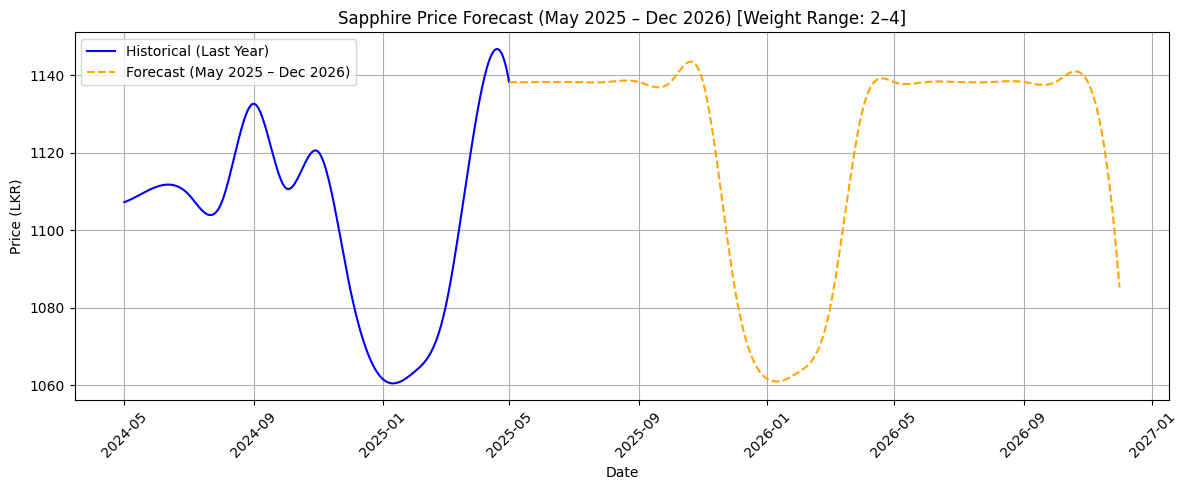

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from datetime import datetime
from scipy.interpolate import make_interp_spline

# Load CSV file (ensure it's uploaded to /content/)
df = pd.read_csv("/content/sapphire.csv")
df.columns = df.columns.str.lower()
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df.dropna(subset=['timestamp'], inplace=True)

# Filter for weight range 2–4 (mapped to 2)
df = df[df['weight_range'] == 2]

# Filter last 1 year of historical data
df = df.sort_values("timestamp")
latest_date = df['timestamp'].max()
one_year_ago = latest_date - pd.DateOffset(years=1)
df_recent = df[df['timestamp'] >= one_year_ago].copy()

#  Feature engineering
df_recent['Year'] = df_recent['timestamp'].dt.year
df_recent['Month'] = df_recent['timestamp'].dt.month

# Train XGBoost model
X = df_recent[['Year', 'Month']]
y = df_recent['price']
model = XGBRegressor(n_estimators=100)
model.fit(X, y)

#  Create future dates from May 2025 to Dec 2026
future_dates = pd.date_range(start='2025-05-01', end='2026-12-01', freq='MS')
future_df = pd.DataFrame({
    'Year': future_dates.year,
    'Month': future_dates.month
})
future_df['Predicted_Price'] = model.predict(future_df)
future_df['Date'] = future_dates

#  Plot historical and forecasted prices
def smooth_plot(x, y, label, color, linestyle='-'):
    if len(x) < 4:
        plt.plot(x, y, label=label, color=color, linestyle=linestyle)
        return
    x_numeric = pd.to_datetime(x).astype(np.int64) // 10**9 // 86400
    spline = make_interp_spline(x_numeric, y, k=3)
    x_smooth = np.linspace(x_numeric.min(), x_numeric.max(), 300)
    y_smooth = spline(x_smooth)
    x_smooth_dt = pd.to_datetime(x_smooth * 86400, unit='s', origin='unix')
    plt.plot(x_smooth_dt, y_smooth, label=label, color=color, linestyle=linestyle)

plt.figure(figsize=(12, 5))
smooth_plot(df_recent['timestamp'], y, 'Historical (Last Year)', 'blue')
smooth_plot(future_df['Date'], future_df['Predicted_Price'], 'Forecast (May 2025 – Dec 2026)', 'orange', linestyle='--')
plt.title("Sapphire Price Forecast (May 2025 – Dec 2026) [Weight Range: 2–4]")
plt.xlabel("Date")
plt.ylabel("Price (LKR)")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()




# Analysis & Predictions:



*   Seasonal Patterns: Decompose time series to detect seasonality, trends, and noise.

*   Rolling Mean/Volatility: Identify stable vs volatile pricing periods.

*   Price Drop Alerts: Flag future periods where prices may fall below average.
*   Top Rising/Falling Gems: Rank by price % change YoY or MoM.


*   Inter-metal Correlation: See if prices of gold and silver move together.






# 2. "COLORTREND" Analysis

Goal: Identify and predict popular gemstone color trends

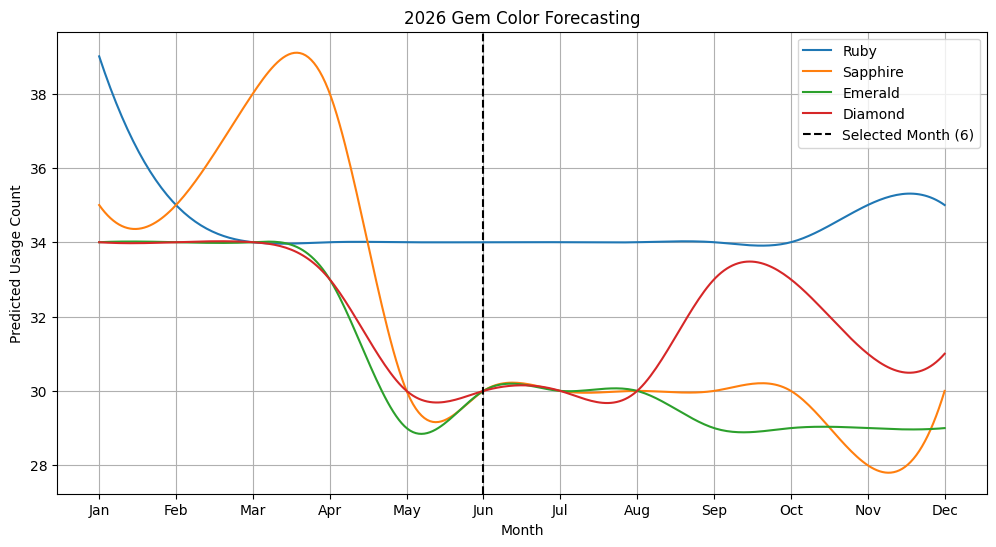

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from scipy.interpolate import make_interp_spline

# Load your data (replace this with your real CSV path)
df = pd.read_csv("/content/colortrend.csv")  # make sure this file is uploaded

# Preprocessing
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df.dropna(subset=['timestamp'], inplace=True)
df['year'] = df['timestamp'].dt.year
df['month'] = df['timestamp'].dt.month

valid_colors = ['Ruby', 'Sapphire', 'Emerald', 'Diamond']
for color in valid_colors:
    df[color] = df[['top_color_1', 'top_color_2', 'top_color_3']].apply(lambda x: sum(x == color), axis=1)

monthly_usage = df.groupby(['year', 'month'])[['Ruby', 'Sapphire', 'Emerald', 'Diamond']].sum().reset_index()

# Train models and predict only for 2026
X = monthly_usage[['year', 'month']]
future = pd.DataFrame({'year': [2026]*12, 'month': list(range(1, 13))})

predicted_df = future.copy()
for gem in valid_colors:
    y = monthly_usage[gem]
    model = XGBRegressor(n_estimators=10, max_depth=2, learning_rate=0.1, verbosity=0)
    model.fit(X, y)
    predicted_df[gem] = model.predict(future).astype(int)

# Line chart with vertical indicator
months = predicted_df['month']
fig, ax = plt.subplots(figsize=(12, 6))
for gem in valid_colors:
    y_smooth = make_interp_spline(months, predicted_df[gem])(np.linspace(1, 12, 300))
    ax.plot(np.linspace(1, 12, 300), y_smooth, label=gem)

selected_month = 6
ax.axvline(x=selected_month, color='black', linestyle='--', label=f'Selected Month ({selected_month})')
ax.set_xticks(range(1, 13))
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax.set_xlabel("Month")
ax.set_ylabel("Predicted Usage Count")
ax.set_title("2026 Gem Color Forecasting")
ax.legend()
ax.grid(True)
plt.show()



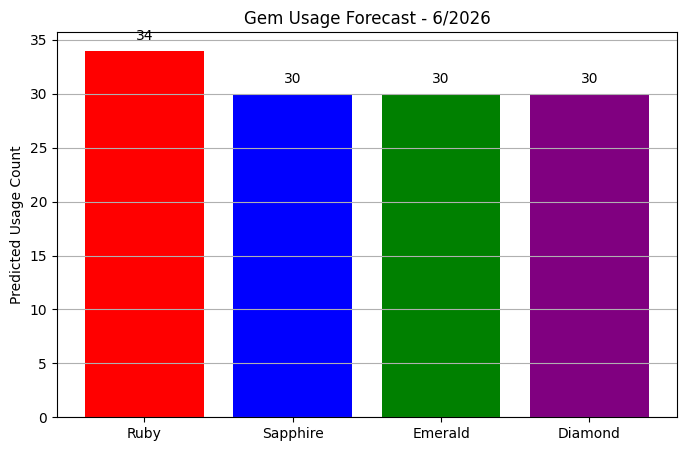

In [ ]:
# Bar chart for selected month
selected_row = predicted_df[predicted_df['month'] == selected_month]
if not selected_row.empty:
    usage = selected_row[valid_colors].values.flatten()
    fig, ax = plt.subplots(figsize=(8, 5))
    bars = ax.bar(valid_colors, usage, color=['red', 'blue', 'green', 'purple'])
    ax.set_ylabel("Predicted Usage Count")
    ax.set_title(f"Gem Usage Forecast - {selected_month}/2026")
    for bar in bars:
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, int(bar.get_height()), ha='center')
    ax.grid(axis='y')
    plt.show()

# Analysis & Predictions:



* Top Colors Over Time: Line chart showing monthly color popularity.

*  Future Color Demand: Predict the most in-demand color per month.
*  Color Shift Patterns: Find when buyers shift from one color to another.


*  Marketing Insight: Use prediction to recommend focus colors to designers.






# 3."MATERIALTREND" Analysis

Goal: Forecast usage of gold vs silver in designs or sales

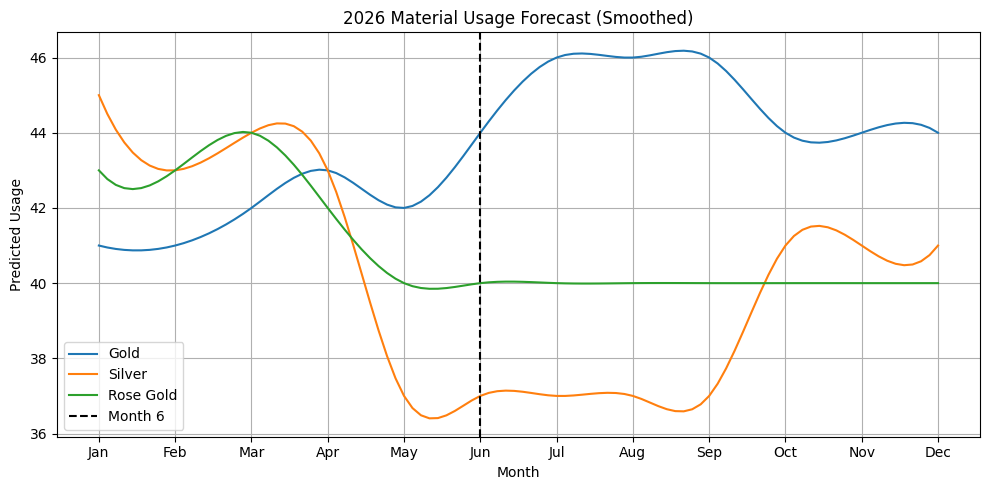

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from scipy.interpolate import make_interp_spline

# Step 1: Load the dataset
df = pd.read_csv("/content/materialtrend.csv", header=None)
df.columns = ['id', 'top_material_1', 'top_material_2', 'top_material_3', 'timestamp']
df.drop(columns=['id'], inplace=True)

# Step 2: Preprocess
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df.dropna(subset=['timestamp'], inplace=True)
df['year'] = df['timestamp'].dt.year
df['month'] = df['timestamp'].dt.month

valid_materials = ['Gold', 'Silver', 'Rose Gold']  # Removed Platinum
for m in valid_materials:
    df[m] = df[['top_material_1', 'top_material_2', 'top_material_3']].apply(lambda x: sum(x == m), axis=1)

monthly_usage = df.groupby(['year', 'month'])[valid_materials].sum().reset_index()

# Step 3: Predict 2026
X = monthly_usage[['year', 'month']]
future = pd.DataFrame({'year': [2026]*12, 'month': list(range(1, 13))})

predicted_df = future.copy()
for material in valid_materials:
    model = XGBRegressor(n_estimators=10, max_depth=2, learning_rate=0.1, verbosity=0)
    model.fit(X, monthly_usage[material])
    predicted_df[material] = model.predict(future).astype(int)

# Step 4: Export to CSV
predicted_df.to_csv("2026_material_prediction.csv", index=False)

# Step 5: Smooth Line Chart
selected_month = 6
plt.figure(figsize=(10, 5))
months = predicted_df['month'].values
x_smooth = np.linspace(months.min(), months.max(), 100)

for m in valid_materials:
    y = predicted_df[m].values
    spline = make_interp_spline(months, y, k=3)
    y_smooth = spline(x_smooth)
    plt.plot(x_smooth, y_smooth, label=m)

plt.axvline(x=selected_month, color='black', linestyle='--', label=f'Month {selected_month}')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.xlabel("Month")
plt.ylabel("Predicted Usage")
plt.title("2026 Material Usage Forecast (Smoothed)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


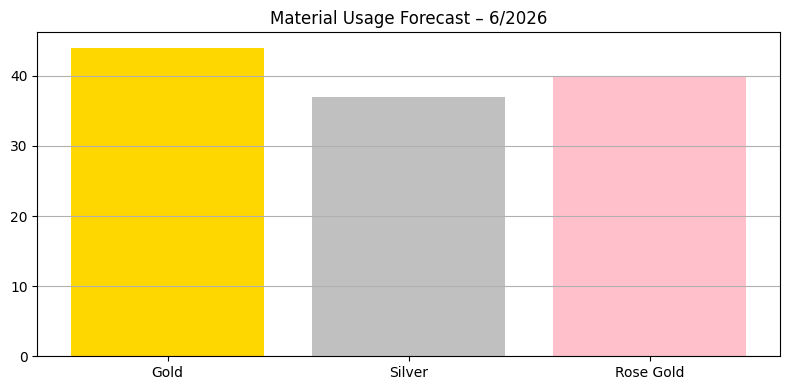

In [ ]:
# Step 6: Bar Chart for selected month
row = predicted_df[predicted_df['month'] == selected_month]
plt.figure(figsize=(8, 4))
plt.bar(valid_materials, row[valid_materials].values.flatten(), color=['gold', 'silver', 'pink'])
plt.title(f"Material Usage Forecast – {selected_month}/2026")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


# Analysis & Predictions:



*   Material Preference Trends: Over time for silver/gold.

*   Material Demand Forecast: Predict usage counts using features like month, user_type, color, gem_type.
*   Material Switching Behavior: Detect shifts in user preferences.




# 4. "STOCK" Analysis

Goal: Predict future inventory needs and optimize stock levels

<ipython-input-25-4e32f0538c02>:58: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(x_actual, y_actual, 'o-', label=f"{column} (2025)", linestyle="-")


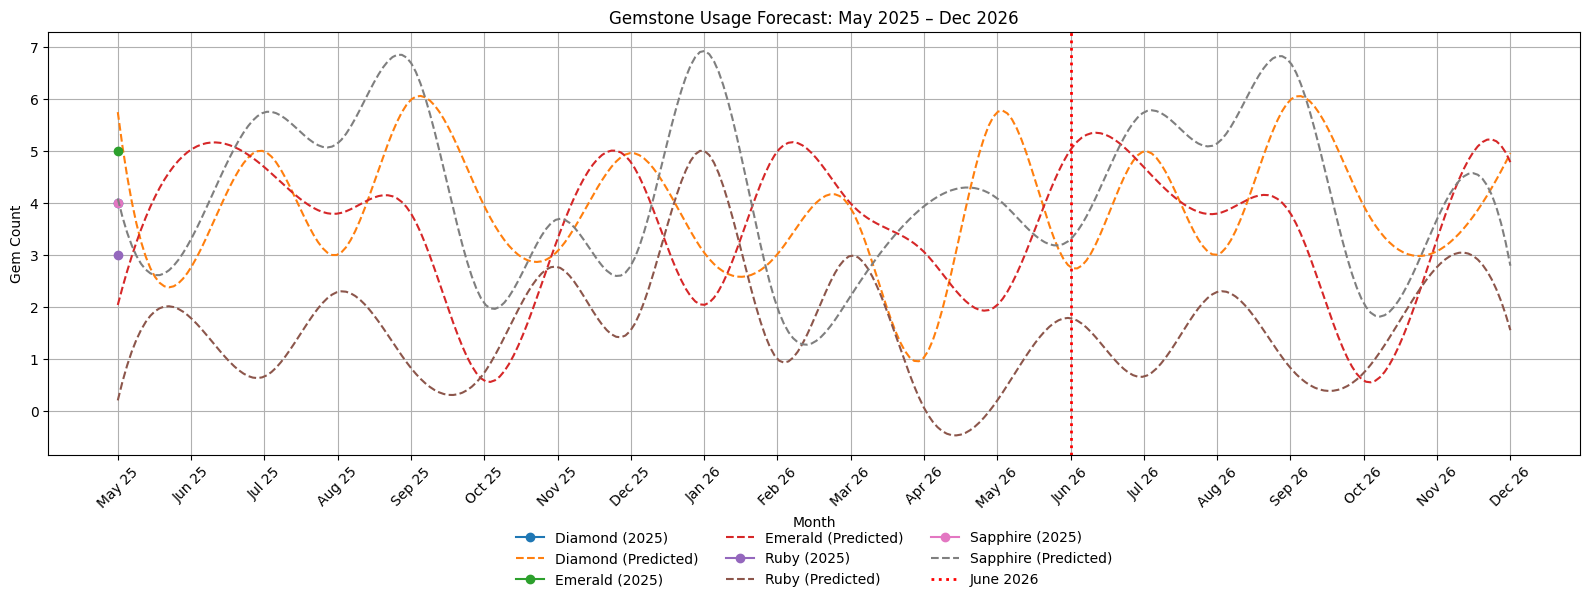

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from scipy.interpolate import make_interp_spline

# Step 1: Load your CSV
df = pd.read_csv("/content/Sequential_Custom_Orders.csv")
df.columns = df.columns.str.lower()
df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce')
df.dropna(subset=['created_at'], inplace=True)

# Step 2: Preprocess
df['year_month'] = df['created_at'].dt.to_period('M')
monthly_counts = df.groupby(['year_month', 'gem_color']).size().unstack(fill_value=0)
monthly_counts.index = monthly_counts.index.to_timestamp()
monthly_counts = monthly_counts.asfreq('MS')

# Step 3: Prepare training data (until April 2025)
train_data = monthly_counts[monthly_counts.index <= '2025-04-01'].copy()
train_data['month'] = train_data.index.month
train_data['year'] = train_data.index.year

X = train_data[['year', 'month']]
y = train_data.drop(columns=['year', 'month'], errors='ignore')

# Step 4: Train the model
model = MultiOutputRegressor(XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42))
model.fit(X, y)

# Step 5: Predict from May 2025 to December 2026
future_dates = pd.date_range(start="2025-05-01", end="2026-12-01", freq='MS')
future_df = pd.DataFrame({'year': future_dates.year, 'month': future_dates.month})
predictions = model.predict(future_df)
prediction_df = pd.DataFrame(predictions, index=future_dates, columns=y.columns)

# Step 6: Plot smoothed line chart (May-Dec 2025 actual vs May 2025–Dec 2026 predicted)
actual_data = monthly_counts[(monthly_counts.index >= '2025-05-01') & (monthly_counts.index <= '2025-12-01')].copy()
months = prediction_df.index.strftime('%b %y')

fig, ax = plt.subplots(figsize=(16, 7))
x_actual = np.arange(len(actual_data))
x_pred = np.arange(len(prediction_df))

for column in y.columns:
    # Plot actual values
    if column in actual_data.columns:
        y_actual = actual_data[column].values
        # Check if there are enough points for smoothing
        if len(x_actual) >= 4:
            x_smooth_actual = np.linspace(x_actual.min(), x_actual.max(), 300)
            spline_actual = make_interp_spline(x_actual, y_actual, k=3)
            y_smooth_actual = spline_actual(x_smooth_actual)
            ax.plot(x_smooth_actual, y_smooth_actual, label=f"{column} (2025)", linestyle="-")
        else:
            # Plot actual points if not enough for smoothing
            ax.plot(x_actual, y_actual, 'o-', label=f"{column} (2025)", linestyle="-")


    # Plot predicted values
    y_pred = prediction_df[column].values
    x_smooth_pred = np.linspace(x_pred.min(), x_pred.max(), 300)
    spline_pred = make_interp_spline(x_pred, y_pred, k=3)
    y_smooth_pred = spline_pred(x_smooth_pred)
    ax.plot(x_smooth_pred, y_smooth_pred, label=f"{column} (Predicted)", linestyle="--")

# Format x-axis
ax.set_xticks(x_pred)
ax.set_xticklabels(months, rotation=45)

# Highlight June 2026
# Check if the date exists in the index before getting the location
if pd.to_datetime('2026-06-01') in prediction_df.index:
    ax.axvline(x=prediction_df.index.get_loc('2026-06-01'), color='red', linestyle=':', linewidth=2, label='June 2026')


# Labels and formatting
ax.set_title("Gemstone Usage Forecast: May 2025 – Dec 2026")
ax.set_xlabel("Month")
ax.set_ylabel("Gem Count")
ax.grid(True)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, frameon=False)
plt.tight_layout(rect=[0, 0.1, 1, 1])
plt.show()



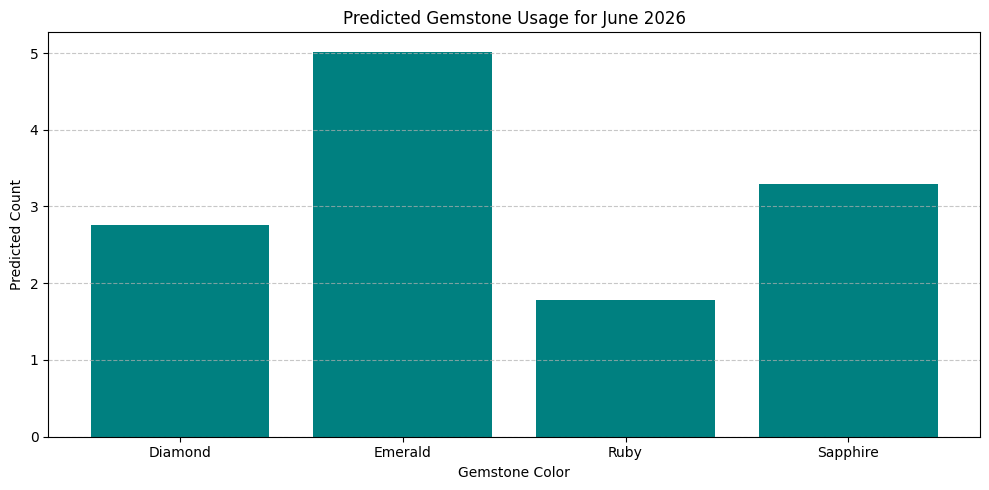

In [ ]:
# Step 7: Bar chart for June 2026
selected_date = pd.to_datetime("2026-06-01")
if selected_date in prediction_df.index:
    month_data = prediction_df.loc[selected_date]
    fig2, ax2 = plt.subplots(figsize=(10, 5))
    ax2.bar(month_data.index, month_data.values, color='teal')
    ax2.set_title("Predicted Gemstone Usage for June 2026")
    ax2.set_xlabel("Gemstone Color")
    ax2.set_ylabel("Predicted Count")
    ax2.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print(" Forecast data not available for June 2026.")

#Analysis & Predictions:




*   Stock Level Forecasting: Predict quantity needed for each gemstone using regression.

*   Out-of-Stock Prediction: Classify which items risk going out-of-stock next month.
*   Demand-Supply Mismatch: Compare predicted demand vs current stock.


*  Stock Refill Cycle: Estimate average restock time for each material.


#5. Customer Segmentation

Goal: Group users based on their buying patterns.

This code segments users into two groups based on their color and material preferences using K-Means clustering. It processes the data, encodes preferences, finds the best number of clusters, and visualizes the results using PCA.

Silhouette Score (k=2): 0.14


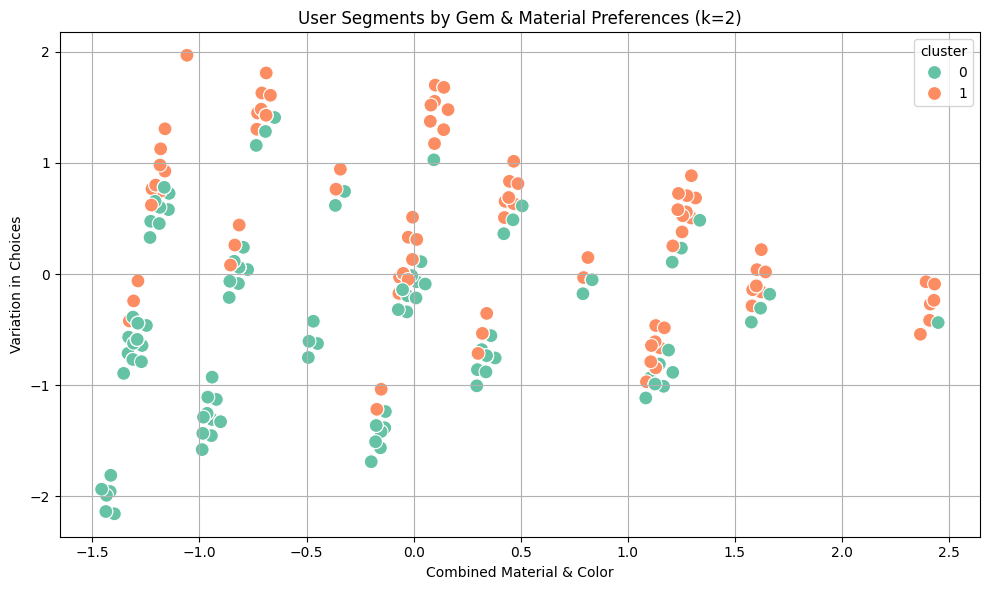

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# Step 1: Load CSV
df = pd.read_csv("User_Behavior_with_Final_Timestamps.csv")
df.columns = df.columns.str.lower()

# Step 2: Combine color and material preferences
color_cols = ['top_color_1', 'top_color_2', 'top_color_3']
material_cols = ['top_material_1', 'top_material_2', 'top_material_3']

df_colors = df[color_cols].fillna('None')
df_materials = df[material_cols].fillna('None')

# Merge colors and materials into strings
df_long = pd.concat([
    df[['id']],
    df_colors.apply(lambda x: ','.join(x), axis=1).rename('color_pref'),
    df_materials.apply(lambda x: ','.join(x), axis=1).rename('material_pref')
], axis=1)

# Convert to list
df_long['color_pref'] = df_long['color_pref'].str.split(',')
df_long['material_pref'] = df_long['material_pref'].str.split(',')

# Flatten out to long form for one-hot encoding
df_expanded = pd.DataFrame({
    'id': df_long['id'].repeat(df_long['color_pref'].str.len()),
    'color': sum(df_long['color_pref'].tolist(), []),
    'material': sum(df_long['material_pref'].tolist(), [])
})

# Remove invalid entries
df_expanded = df_expanded[(df_expanded['color'] != 'None') & (df_expanded['material'] != 'None')]

# One-hot encode colors and materials
encoded = pd.get_dummies(df_expanded[['color', 'material']])

# Group and prepare feature vectors per user
user_features = encoded.groupby(df_expanded['id']).sum()

# Step 3: Apply KMeans with best k = 2
best_k = 2
kmeans = KMeans(n_clusters=best_k, random_state=42)
user_features['cluster'] = kmeans.fit_predict(user_features)

# Step 4: Evaluate silhouette score
score = silhouette_score(user_features.drop(columns='cluster'), user_features['cluster'])
print(f"Silhouette Score (k={best_k}):", round(score, 3))

# Step 5: Reduce dimensions using PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(user_features.drop(columns='cluster'))
user_features['Preference Axis 1'] = pca_result[:, 0]
user_features['Preference Axis 2'] = pca_result[:, 1]

# Step 6: Visualize the clusters with meaningful axis names
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=user_features,
    x='Preference Axis 1',
    y='Preference Axis 2',
    hue='cluster',
    palette='Set2',
    s=100
)
plt.title("User Segments by Gem & Material Preferences (k=2)")
plt.xlabel("Combined Material & Color")
plt.ylabel("Variation in Choices")
plt.grid(True)
plt.tight_layout()
plt.show()


#Insights from the Graph

1. **Two Clear Customer Segments**:

   * The plot confirms that users can be grouped into **two distinct clusters** (Cluster 0 and Cluster 1), indicating differing gem and material preferences.

2. **Diverse Preference Patterns**:

   * The **horizontal axis (Combined Material & Color)** shows variations in the **type of materials and gem colors** users prefer.
   * The **vertical axis (Variation in Choices)** reflects how **broad or narrow** those preferences are (e.g., users who explore many combinations vs. those who stick to a few).

3. **Cluster Distribution**:

   * Cluster 0 (e.g., green) users may lean toward one consistent set of color-material combinations.
   * Cluster 1 (e.g., orange) users likely explore more variety or have different material preferences altogether.

4. **Potential Targeting Strategy**:

   * Each cluster can be targeted with personalized marketing:

     * **Cluster 0**: Promote bestselling items based on fixed color/material combinations.
     * **Cluster 1**: Highlight new arrivals or customizable combinations, appealing to their broader tastes.

5. **Design & Stock Decisions**:

   * If many users fall into one cluster, it can guide inventory planning (e.g., stock more silver-sapphire combos if Cluster 0 dominates).


# 6. Material Trend Clustering

Objective: Discover materials (Gold, Silver, Rose Gold) that follow similar monthly usage trends

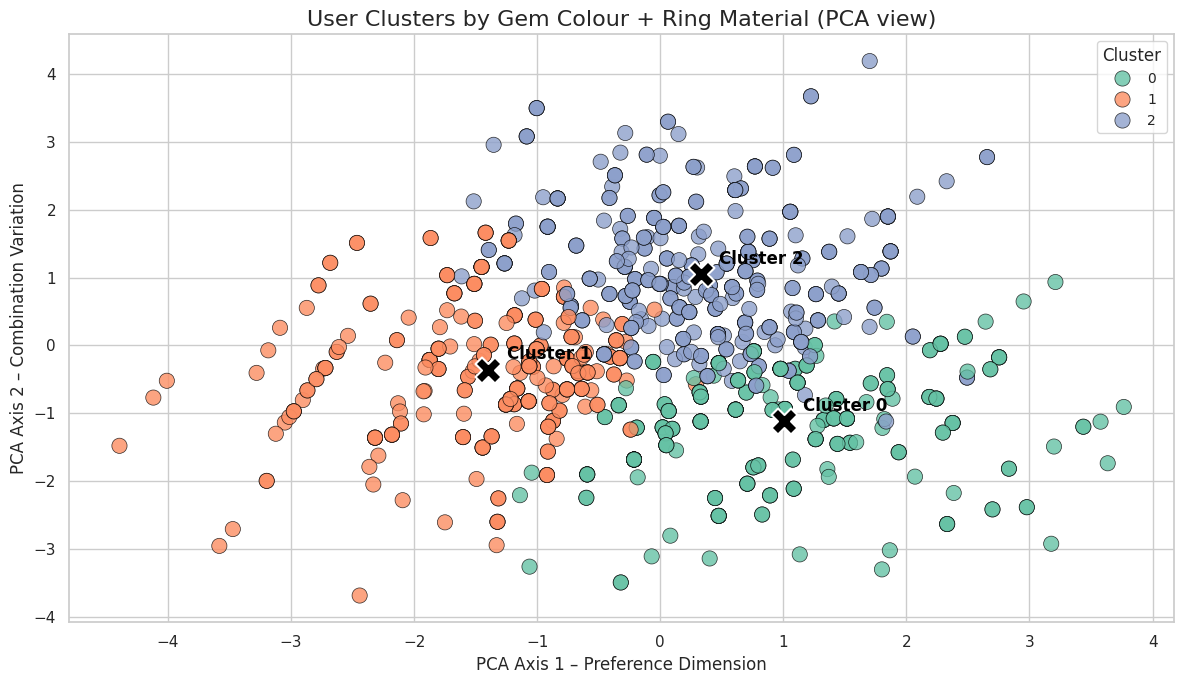

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


# 1. Load & tidy the data

df = pd.read_csv("/content/User_Behavior_with_Final_Timestamps.csv")
df.columns = df.columns.str.lower()

gem_cols = ['top_color_1', 'top_color_2', 'top_color_3']
mat_cols = ['top_material_1', 'top_material_2', 'top_material_3']

# keep rows where at least one gem OR one material was chosen
df = df[['id'] + gem_cols + mat_cols].dropna(how='all', subset=gem_cols + mat_cols)


# 2. Build colour-material “combo” features per user

gems_long = df.melt(id_vars='id', value_vars=gem_cols,
                    value_name='color').dropna(subset=['color'])
mats_long = df.melt(id_vars='id', value_vars=mat_cols,
                    value_name='material').dropna(subset=['material'])

# cartesian join on id → every colour paired with every material the user picked
pairs = gems_long.merge(mats_long, on='id')
pairs['combo'] = pairs['color'] + ' + ' + pairs['material']

# one-hot encode combos then aggregate per user
encoded = pd.get_dummies(pairs[['id', 'combo']], columns=['combo'])
user_mat = encoded.groupby('id').sum()


# 3. Scale, cluster, reduce dimension

scaler = StandardScaler()
X_scaled = scaler.fit_transform(user_mat)

k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
user_mat['cluster'] = kmeans.fit_predict(X_scaled)

pca = PCA(n_components=2, random_state=42)
pca_coords = pca.fit_transform(X_scaled)
user_mat['pca1'], user_mat['pca2'] = pca_coords[:, 0], pca_coords[:, 1]

# transform cluster centroids to PCA space
centroids_pca = pca.transform(kmeans.cluster_centers_)


# 4. Plot – clearer scatter with centroids & labels

plt.figure(figsize=(12, 7))
sns.set(style="whitegrid")

scatter = sns.scatterplot(
    data=user_mat,
    x='pca1', y='pca2',
    hue='cluster',
    palette='Set2',
    s=120,        # bigger points
    alpha=0.8,
    edgecolor='black',
    linewidth=0.5
)

# draw centroids
for idx, (cx, cy) in enumerate(centroids_pca):
    plt.scatter(cx, cy, s=350, c='black', marker='X', edgecolor='white', linewidths=1.5, zorder=5)
    plt.text(cx + 0.15, cy + 0.15, f'Cluster {idx}', fontsize=12, weight='bold', color='black')

# cosmetics
plt.title("User Clusters by Gem Colour + Ring Material (PCA view)", fontsize=16)
plt.xlabel("PCA Axis 1 – Preference Dimension", fontsize=12)
plt.ylabel("PCA Axis 2 – Combination Variation", fontsize=12)
plt.legend(title="Cluster", fontsize=10)
plt.tight_layout()
plt.show()









1.   Cluster 0 (Green - bottom-right quadrant)

Profile: Bold and Consistent Choosers

These users share highly consistent gem+material combinations.

Likely favor a few dominant combos (e.g., Sapphire + Silver or Ruby + Gold).

The tight grouping suggests strong shared taste and focused preferences.

Business Strategy:

Recommend bundled products based on their known favorites.

Run limited edition promos targeting their preferred pairs.


2.  Cluster 1 (Orange - far left quadrant)


Profile: Diverse and Niche Preference Users

These users are more spread out, indicating more variation in selections.

Possibly experiment with less common combinations like Emerald + Rose Gold, or mix multiple styles.

Business Strategy:

Offer personalized suggestions or "build your own set" features.

Could respond well to customization tools and dynamic try-on apps.




3.   Cluster 2 (Blue - top-central quadrant)
Profile: Trend-Aligned Users

Form a dense and central cluster, suggesting common but varied tastes.

These users might choose from popular options but don’t heavily lean on just one.

Business Strategy:

Target with best-sellers, seasonal campaigns, or "most loved" combos.

Serve as a stable market for both classic and trending items.